In [1]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras import Model
from tensorflow.keras.initializers import RandomNormal, RandomUniform
from tensorflow.keras.optimizers import Adam

In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Load Seurat processed counts and annotations

In [3]:
import pandas as pd
datadir = '/data/leslie/sinhaa2/cellmem/data/seurat/'

labels = np.array(pd.read_csv(datadir+'marrow_labels.csv')['x'])    # labels (#cell,)
counts = pd.read_csv(datadir+'marrow_pca.csv', index_col=0)             # counts (#cell, #genes)
M = counts.to_numpy()
counts.head()

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10
A22.D042044.3_9_M.1.1,-5.860719,9.213761,-0.130280,2.123635,-2.034835,-0.195282,-0.283697,-1.887902,-1.584474,-1.354881
C5.D042044.3_9_M.1.1,-7.581568,2.231928,-6.599396,7.981637,14.452710,0.176056,5.856105,5.052887,1.024149,3.186036
D10.D042044.3_9_M.1.1,-5.637471,6.998604,-4.260548,1.826997,0.994635,-0.504240,4.459742,-4.750789,0.597697,-0.416853
E13.D042044.3_9_M.1.1,-2.745625,3.751343,15.350243,4.742908,-6.545429,25.918229,3.000788,2.535475,0.222095,-0.057832
F19.D042044.3_9_M.1.1,-7.819853,0.870509,-6.458527,8.297320,14.339286,0.562475,5.773389,6.569072,1.399685,3.112929


## UMAP visualization

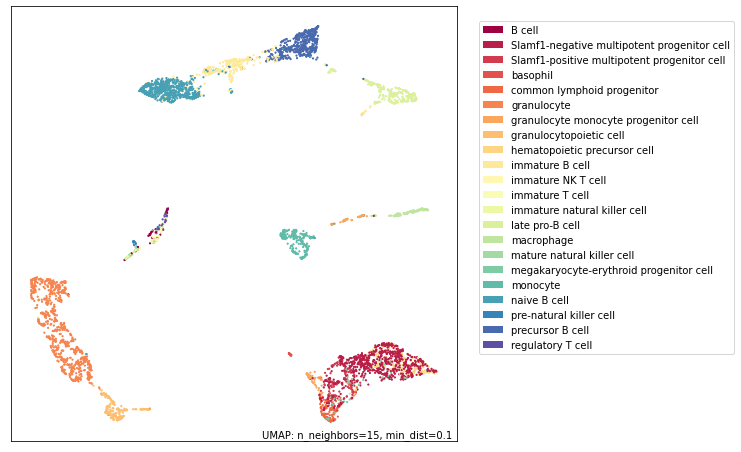

In [4]:
import umap
import umap.plot

mapper = umap.UMAP().fit(M)
ax = umap.plot.points(mapper, labels=labels)
legend = ax.get_legend()
ax.legend(legend.legendHandles, (x.get_text() for x in legend.get_texts()), loc=(1.05,0.2))
plt.show()

## Cellular Memories training

In [14]:
N2 = len(np.unique(labels))       # memories
Ns, N1 = M.shape
MS = 1

mu = 0.01
sigma = 0.01
N_steps = 3

beta = 1.
R0 = 3 

batch_size = Ns//100
eps = 0.02          # ADAM lr
N_ep = 500        # epochs

tau = 1.0
dt = 0.2

In [15]:
class MHN_WITH_1_HIDDEN_LAYER(tf.keras.layers.Layer):
    def __init__(self, N1=N1, N2=N2, **kwargs):
        super().__init__(**kwargs)
        self.N1 = N1
        self.N2 = N2        

    def build(self, input_shape):
        self.kernel = self.add_weight(
            "kernel",
            shape=[self.N1, self.N2],
            initializer=RandomNormal(mean=mu, stddev=sigma, seed=None)
        )
        self.beta = self.add_weight(
            "beta",
            shape=[1, 1],
            initializer=RandomNormal(mean=beta, stddev=0.01, seed=None)
        )
        self.R = self.add_weight(
            "R",
            shape=[1, 1],
            initializer=RandomNormal(mean=R0, stddev=0.01, seed=None)
        )
        self.alpha = self.add_weight(
            "alpha",
            shape=[1, 1],
            initializer=RandomNormal(mean=dt/tau, stddev=0.01, seed=None)
        )
        
        super().build(input_shape)

    def call(self, v, mask):   # one iteration of visible unit update
        nc = tf.sqrt(tf.reduce_sum(tf.square(self.kernel), axis=[0]))
        Mem = self.kernel/nc*self.R       # Memories
        
        h = tf.matmul(v,Mem)              # hidden units
        SM = tf.nn.softmax(self.beta*h)
        U = tf.matmul(SM, tf.transpose(Mem)) - v
        return [v + self.alpha*U*mask, SM]
                    

In [16]:
tf.keras.backend.clear_session()

input_mask = Input(shape=[N1])
input1 = Input(shape=[N1])
MHN_cell = MHN_WITH_1_HIDDEN_LAYER(N1, N2)

# define model
x, SM = MHN_cell(input1, input_mask)
for _ in range(N_steps-1):
    x, SM = MHN_cell(x, input_mask)

model = Model(inputs=[input1, input_mask], outputs=x)

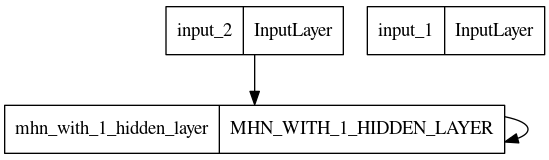

In [17]:
tf.keras.utils.plot_model(model)

In [18]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 mhn_with_1_hidden_layer (MHN_W  [(None, 10),        223         ['input_2[0][0]',                
 ITH_1_HIDDEN_LAYER)             (None, 22)]                      'input_1[0][0]',                
                                                                  'mhn_with_1_hidden_layer[0][0]',
                                                                  'input_1[0][0]',            

In [19]:
optimizer = Adam(learning_rate=eps)

train_dataset = tf.data.Dataset.from_tensor_slices((M, M))
train_dataset = train_dataset.shuffle(Ns).batch(batch_size)

In [20]:
def print_status_bar(iteration, total, loss, metrics=None):
    metrics = ' - '.join(["{}: {:.4f}".format('loss', m) for m in [loss] + (metrics or [])])
    end = '' if iteration < total else '\n'
    print('\r{}/{} - '.format(iteration, total) + metrics, end=end)

In [21]:
def mean_squared_error(y_true, y_pred):
    loss = tf.reduce_mean(tf.square(y_true-y_pred))*N1/MS
    return loss

In [22]:
for epoch in range(1, N_ep+1):
    print(f'Epoch {epoch}/{N_ep}')

    for step, (x_train, y_train) in enumerate(train_dataset):
        # masking training data
        x_train = tf.cast(x_train,dtype=tf.float32)
        y_train = tf.cast(y_train,dtype=tf.float32)
        mask = np.zeros_like(x_train)
        for i in range(len(x_train)):
            idx = np.random.choice(N1, MS, replace=False)
            mask[i,idx] = 1.
        mask = tf.convert_to_tensor(mask, dtype=tf.float32)
        x_train_masked = x_train*tf.cast(1.0-mask, dtype=tf.float32)
        
        # update weights
        with tf.GradientTape() as tape:
            y_pred = model([x_train_masked, mask])
            loss = mean_squared_error(y_train, y_pred)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.learning_rate.assign(eps)
        optimizer.apply_gradients(zip(gradients[:1], model.trainable_variables[:1]))
        
        optimizer.learning_rate.assign(eps/10)
        optimizer.apply_gradients(zip(gradients[1:], model.trainable_variables[1:]))

        for _ in range(1,len(model.trainable_variables)):
            model.trainable_variables[_].assign(tf.clip_by_value(model.trainable_variables[_], 0.01, 100))
        
        
        #print_status_bar
        print_status_bar((step+1)*batch_size, Ns, tf.sqrt(loss))

        # plot weights
        memories = model.layers[2].get_weights()[0].T
        current_beta = model.layers[2].get_weights()[1][0][0]
        current_R = model.layers[2].get_weights()[2][0][0]
        current_alpha = model.layers[2].get_weights()[3][0][0]
    print('Current beta is: ', current_beta, ', current R is: ', current_R, ', current alpha is: ', current_alpha)
    

Epoch 1/500


2022-06-07 15:26:05.554258: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


5050/5037 - loss: 5.3556
Current beta is:  1.119717 , current R is:  3.2725725 , current alpha is:  0.43390864
Epoch 2/500
5050/5037 - loss: 6.2242
Current beta is:  1.114989 , current R is:  3.5553508 , current alpha is:  0.5881277
Epoch 3/500
5050/5037 - loss: 5.8856
Current beta is:  1.074946 , current R is:  3.8353837 , current alpha is:  0.6957696
Epoch 4/500
5050/5037 - loss: 4.1309
Current beta is:  1.0420573 , current R is:  4.108389 , current alpha is:  0.7734577
Epoch 5/500
5050/5037 - loss: 3.1882
Current beta is:  1.0042967 , current R is:  4.3461485 , current alpha is:  0.82372785
Epoch 6/500
5050/5037 - loss: 5.4484
Current beta is:  0.99980414 , current R is:  4.587042 , current alpha is:  0.86153
Epoch 7/500
5050/5037 - loss: 3.1796
Current beta is:  0.93911076 , current R is:  4.820429 , current alpha is:  0.89011633
Epoch 8/500
5050/5037 - loss: 4.1187
Current beta is:  0.8914802 , current R is:  5.021099 , current alpha is:  0.9093076
Epoch 9/500
5050/5037 - loss: 5.

5050/5037 - loss: 3.1426
Current beta is:  0.11273512 , current R is:  10.503679 , current alpha is:  2.037129
Epoch 68/500
5050/5037 - loss: 4.3056
Current beta is:  0.11289929 , current R is:  10.502801 , current alpha is:  2.0378585
Epoch 69/500
5050/5037 - loss: 4.1386
Current beta is:  0.09265484 , current R is:  10.482904 , current alpha is:  2.0458896
Epoch 70/500
5050/5037 - loss: 4.3749
Current beta is:  0.13327304 , current R is:  10.500578 , current alpha is:  2.034332
Epoch 71/500
5050/5037 - loss: 3.6750
Current beta is:  0.14733702 , current R is:  10.497148 , current alpha is:  1.9980686
Epoch 72/500
5050/5037 - loss: 1.5008
Current beta is:  0.14092556 , current R is:  10.492677 , current alpha is:  2.011907
Epoch 73/500
5050/5037 - loss: 1.8051
Current beta is:  0.1281243 , current R is:  10.488525 , current alpha is:  2.0210376
Epoch 74/500
5050/5037 - loss: 2.3428
Current beta is:  0.12506266 , current R is:  10.497753 , current alpha is:  2.0324101
Epoch 75/500
5050

5050/5037 - loss: 2.7253
Current beta is:  0.10668285 , current R is:  10.508626 , current alpha is:  2.0502725
Epoch 134/500
5050/5037 - loss: 2.4081
Current beta is:  0.14658362 , current R is:  10.534608 , current alpha is:  2.0443826
Epoch 135/500
5050/5037 - loss: 1.8719
Current beta is:  0.13948129 , current R is:  10.52553 , current alpha is:  2.0314078
Epoch 136/500
5050/5037 - loss: 3.6481
Current beta is:  0.10236244 , current R is:  10.493942 , current alpha is:  2.0412128
Epoch 137/500
5050/5037 - loss: 2.2687
Current beta is:  0.11983377 , current R is:  10.505085 , current alpha is:  2.044414
Epoch 138/500
5050/5037 - loss: 2.0359
Current beta is:  0.11246505 , current R is:  10.518228 , current alpha is:  2.0561595
Epoch 139/500
5050/5037 - loss: 2.3161
Current beta is:  0.1270319 , current R is:  10.533172 , current alpha is:  2.0472353
Epoch 140/500
5050/5037 - loss: 1.4160
Current beta is:  0.1125372 , current R is:  10.539564 , current alpha is:  2.053482
Epoch 141/5

5050/5037 - loss: 2.3491
Current beta is:  0.10960471 , current R is:  10.859945 , current alpha is:  2.097897
Epoch 199/500
5050/5037 - loss: 3.6222
Current beta is:  0.1060475 , current R is:  10.868381 , current alpha is:  2.1057286
Epoch 200/500
5050/5037 - loss: 2.4618
Current beta is:  0.12931734 , current R is:  10.880398 , current alpha is:  2.0775998
Epoch 201/500
5050/5037 - loss: 1.8054
Current beta is:  0.16824852 , current R is:  10.911563 , current alpha is:  2.064153
Epoch 202/500
5050/5037 - loss: 2.3429
Current beta is:  0.169437 , current R is:  10.902755 , current alpha is:  2.0214753
Epoch 203/500
5050/5037 - loss: 2.2480
Current beta is:  0.16341215 , current R is:  10.882803 , current alpha is:  2.0028548
Epoch 204/500
5050/5037 - loss: 3.2130
Current beta is:  0.15739611 , current R is:  10.870366 , current alpha is:  2.0380023
Epoch 205/500
5050/5037 - loss: 2.0870
Current beta is:  0.14558904 , current R is:  10.849302 , current alpha is:  2.0483851
Epoch 206/5

5050/5037 - loss: 1.1736
Current beta is:  0.12694767 , current R is:  10.893896 , current alpha is:  2.0629134
Epoch 265/500
5050/5037 - loss: 3.3624
Current beta is:  0.12089544 , current R is:  10.8884325 , current alpha is:  2.066659
Epoch 266/500
5050/5037 - loss: 1.4916
Current beta is:  0.118257225 , current R is:  10.888096 , current alpha is:  2.060376
Epoch 267/500
5050/5037 - loss: 3.6562
Current beta is:  0.124312624 , current R is:  10.899642 , current alpha is:  2.0795524
Epoch 268/500
5050/5037 - loss: 2.4107
Current beta is:  0.11823594 , current R is:  10.897184 , current alpha is:  2.072567
Epoch 269/500
5050/5037 - loss: 1.8749
Current beta is:  0.13938282 , current R is:  10.912281 , current alpha is:  2.06154
Epoch 270/500
5050/5037 - loss: 2.3653
Current beta is:  0.12404977 , current R is:  10.890205 , current alpha is:  2.0476239
Epoch 271/500
5050/5037 - loss: 1.8604
Current beta is:  0.1184693 , current R is:  10.897205 , current alpha is:  2.0731356
Epoch 272

5050/5037 - loss: 2.2936
Current beta is:  0.13659406 , current R is:  10.959931 , current alpha is:  2.0620592
Epoch 330/500
5050/5037 - loss: 2.1166
Current beta is:  0.12113619 , current R is:  10.9328375 , current alpha is:  2.0554318
Epoch 331/500
5050/5037 - loss: 2.4546
Current beta is:  0.12236829 , current R is:  10.917078 , current alpha is:  2.0593941
Epoch 332/500
5050/5037 - loss: 1.6216
Current beta is:  0.14277178 , current R is:  10.922202 , current alpha is:  2.0312467
Epoch 333/500
5050/5037 - loss: 3.0236
Current beta is:  0.12684228 , current R is:  10.921957 , current alpha is:  2.0510764
Epoch 334/500
5050/5037 - loss: 2.2975
Current beta is:  0.12719746 , current R is:  10.922368 , current alpha is:  2.0525565
Epoch 335/500
5050/5037 - loss: 2.4979
Current beta is:  0.13768864 , current R is:  10.932765 , current alpha is:  2.0370274
Epoch 336/500
5050/5037 - loss: 1.9731
Current beta is:  0.1288649 , current R is:  10.939329 , current alpha is:  2.048437
Epoch 3

5050/5037 - loss: 3.1584
Current beta is:  0.1290078 , current R is:  10.810613 , current alpha is:  2.0558329
Epoch 395/500
5050/5037 - loss: 4.4384
Current beta is:  0.15535751 , current R is:  10.830979 , current alpha is:  2.046309
Epoch 396/500
5050/5037 - loss: 2.3357
Current beta is:  0.15378086 , current R is:  10.825074 , current alpha is:  2.0389285
Epoch 397/500
5050/5037 - loss: 1.9918
Current beta is:  0.17253374 , current R is:  10.853175 , current alpha is:  2.0335293
Epoch 398/500
5050/5037 - loss: 2.6240
Current beta is:  0.16554002 , current R is:  10.842518 , current alpha is:  2.030915
Epoch 399/500
5050/5037 - loss: 2.7187
Current beta is:  0.14537984 , current R is:  10.822725 , current alpha is:  2.046707
Epoch 400/500
5050/5037 - loss: 1.5906
Current beta is:  0.14424029 , current R is:  10.808736 , current alpha is:  2.052991
Epoch 401/500
5050/5037 - loss: 1.8304
Current beta is:  0.14963183 , current R is:  10.80364 , current alpha is:  2.0430164
Epoch 402/50

5050/5037 - loss: 2.1065
Current beta is:  0.14439788 , current R is:  10.95687 , current alpha is:  2.037436
Epoch 461/500
5050/5037 - loss: 1.8669
Current beta is:  0.1302164 , current R is:  10.944011 , current alpha is:  2.0354834
Epoch 462/500
5050/5037 - loss: 2.9947
Current beta is:  0.14169697 , current R is:  10.94289 , current alpha is:  2.0356922
Epoch 463/500
5050/5037 - loss: 1.9822
Current beta is:  0.13043638 , current R is:  10.935236 , current alpha is:  2.052786
Epoch 464/500
5050/5037 - loss: 2.7542
Current beta is:  0.12950397 , current R is:  10.938927 , current alpha is:  2.0632703
Epoch 465/500
5050/5037 - loss: 1.8897
Current beta is:  0.10329458 , current R is:  10.9237585 , current alpha is:  2.0734172
Epoch 466/500
5050/5037 - loss: 4.8659
Current beta is:  0.12376519 , current R is:  10.940824 , current alpha is:  2.0763535
Epoch 467/500
5050/5037 - loss: 1.8972
Current beta is:  0.110640325 , current R is:  10.927998 , current alpha is:  2.0791378
Epoch 468

## Visualizations

In [23]:
print(np.max(M))
print(np.min(M))
print(np.max(memories))
print(np.min(memories))

30.9709662928879
-32.5373560872055
10.074967
-10.815225


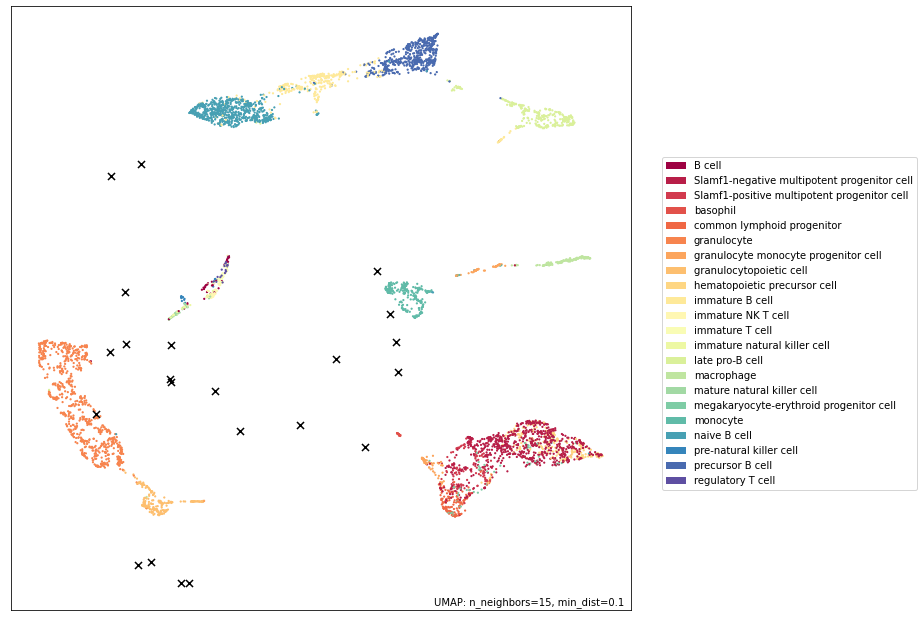

In [25]:
# plot using earlier made UMAP
ax = umap.plot.points(mapper, labels=labels)
legend = ax.get_legend()
ax.legend(legend.legendHandles, (x.get_text() for x in legend.get_texts()), loc=(1.05,0.2))
# add in the embeddings of the MHN learned memories
embedding = mapper.transform(memories)
ax.scatter(memories[:,0], memories[:,1], c='k', s=50, marker='x')
plt.show()